## Create a Basic Model Training Pipeline
This notebook introduces the concept of ML Model Training Pipelines; not to be confused with CI/CD (Continuous Integration/Continuous Delivery) Pipelines such as those available using Azure DevOps. This distinction is quite important because ML Pipelines are frequently integrated with CI/CD pipelines as DevOps practices and tools are adopted for the sake of delivering Machine Learning services; known as MLOps.

In essence, a pipline enables the integration, or chaining together, of two or more activities that are involved in completing a process. In this case, ML Pipelines combine multiple data science & machine learning activities into a single configurable entity. These activities, or steps, would typically include data preparation and preprocessing, model training and validation, model deployment, and batch scoring using that model. 

ML Pipelines provide a consistent and reproducible mechanism for building, evaluating, deploying, and running ML systems.  They alos facilitate reuse by allowing multiple users to share and reuse workflows! ML Pipelines can serve as templates that expedite future Machine Learning development activities.

Model Training Pipelines are available via a variety of ML development frameworks like Scikit-Learn and Keras as well as the Azure Machine Learning SDK.  This notebook aims to introduce ML Pipelines with the greatest level of clarity by eliminating activities that involve infrastructure, and by focusing entirely on Machine Learning activities using Scikit-Learn pipelines. In a future Notebook, I will introduce integration with Azure Machine Learning Workspaces, compute resources, and deployment infrastructure.

### Import Required Libraries

In [1]:
import os
import copy
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import auc, roc_curve, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Define Global Functions for Visualizations

In [2]:
CLASSIFICATION_TYPE = 'Binary'

###################################################################################################################
# Calculate the Null Accuracy Score: Accommodates Binary or Multiple Classification Type
###################################################################################################################
def null_accuracy_score(labels, classification_type):  #NOTE: 'labels' must be a pd.Series
    if classification_type == CLASSIFICATION_TYPE:
        return max(labels[:,].astype(int).mean(), 1 - labels[:,].astype(int).mean())
    
    elif classification_type == CLASSIFICATION_TYPE:
        return labels.value_counts().head(1).item() / len(labels) 
    
    else:
        raise ValueError("Bad input {0}. Must specify either 'Binary' or 'Multiple'.".format(classification_type))


##################################################################################################################
# Print Evaluation Metrics: Accuracy and Null Accuracy Scores
###################################################################################################################
def show_accuracy(y_actuals, y_predictions, classification_type):
    accuracy = accuracy_score(y_actuals, y_predictions)
    null_accuracy = null_accuracy_score(y_actuals, classification_type)

    print('----------------------------------------------------------------------------------')
    print('Accuracy (The Percentage of Correct Predictions): %0.3f' % accuracy)
    print('----------------------------------------------------------------------------------')
    print('Null Accuracy (Achieved by Always Predicting the Most Frequent Class): %0.3f' % null_accuracy)
    print('----------------------------------------------------------------------------------')   
    print('True:', list(y_actuals[0:10]))
    print('Pred:', y_predictions[0:10].tolist())
    print('----------------------------------------------------------------------------------\n')
        

###################################################################################################################
# Print a Confusion Matrix:  Accommodates Binary or Multiple Classification Type
###################################################################################################################
def show_confusion_matrix(y_actuals, y_predictions, y_probabilities, classification_type):
    print('-------------------------------------------------------')
    print('Confusion Matrix')
    print('-------------------------------------------------------')

    cm = pd.crosstab(y_actuals, y_predictions, rownames=['Actuals'], colnames=['Predictions'])
    print(cm)
        
    if classification_type == CLASSIFICATION_TYPE:
        print('-------------------------------------------------------')
        print('Area Under the Curve (AUC): %0.3f' % roc_auc_score(y_actuals, y_probabilities[:, 1]))
        
    print('-------------------------------------------------------\n')
    

###################################################################################################################
# Print a Receiver Operating Characteristic (ROC) Curve Plot (Binary Classification Only).
###################################################################################################################
def show_roc_plot(y_actuals, y_probabilities, classifier_algorithm):
    plt.figure(figsize=(5,5))
    plt.title('ROC Curve (' + classifier_algorithm + ')')

    fpr, tpr, _ = roc_curve(y_actuals, y_probabilities[:, 1])
    auc = roc_auc_score(y_actuals, y_probabilities[:, 1])

    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color='steelblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

### Load the Dataset

In [3]:
# Locate the Data File to be Ingested. 
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.csv')

# Read the Data from the Source File
df = pd.read_csv(source_file, header=0, index_col=0)

# Drop the Unique Identifier
df = df.drop(labels=['Customerid'], axis=1)

# Display the Dimensions of the DataSet.
print("Observations (Rows): ", len(df))
print("Features (Columns): ", len(df.columns))

Observations (Rows):  7043
Features (Columns):  20


### Separate the Dependent (Target) Feature from the Independent Features (Predictors)

In [4]:
X = df.drop(labels=['Churn'], axis=1)
y = df.Churn

### Perform a Train / Test Split
- Perform the Train/Test Split **Before** any Processing to Avoid Target Leakage!

In [5]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=42,
                                                      stratify=y)

### Define Data Processing Pipeline Steps
- Define Separate Pipeline Steps for Processing Numerical and Categorical Features
- Integrate the two Steps into a Single Preprocessing Step using the ColumnTransformer

In [6]:
# Impute Missing Values using the Mean (default)
# Scale Numerical Features
numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),  # SimpleImputer(strategy="mean")
        ("scaler", StandardScaler()),
    ]
)

# Impute Missing Values using the Most Frequent Value
# Encode Categoric Features (One-Hot) 
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine the Preprocessing Steps into a Single Transformer Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

### Define the Model Training Pipeline
- Specify the Data Preprocessing Pipeline as the First Step
- Specify the Estimator (Machine Learning Algorithm) as the Final Step

In [7]:
predictor = Pipeline(
    steps=[
        ("preprocessor", copy.deepcopy(preprocessor)),
        ("classifier", LogisticRegression(solver="liblinear", fit_intercept=True))
    ]
)

### Train the Model

In [8]:
predictor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fca0d6972e8>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

### Render Predictions Using the Test Dataset

In [9]:
y_pred = predictor.predict(X_test)
y_probs = predictor.predict_proba(X_test)

#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.804
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.735
----------------------------------------------------------------------------------
True: [1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Pred: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions     0    1
Actuals               
0            1381  171
1             243  318
-------------------------------------------------------
Area Under the Curve (AUC): 0.843
-------------------------------------------------------



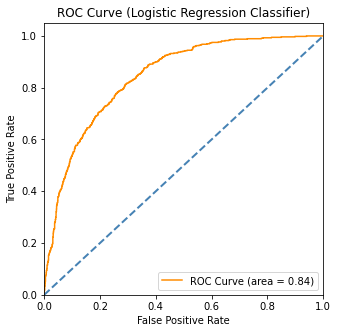

In [10]:
show_accuracy(y_test, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_test, y_pred, y_probs, CLASSIFICATION_TYPE)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_test, y_probs, 'Logistic Regression Classifier')